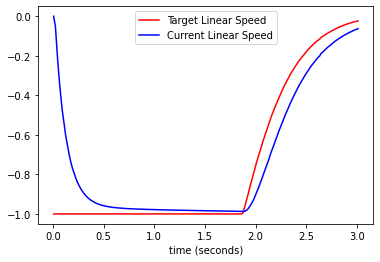

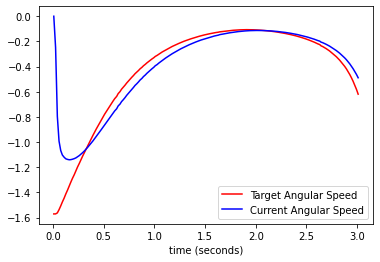

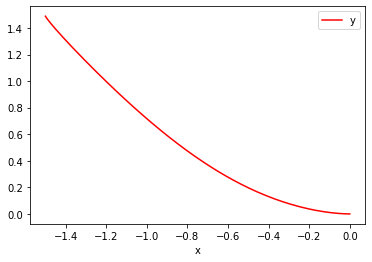

In [5]:
import sys
sys.path.append("../../")

#
# TO BE USED WITH godot/card2D_no_physics
#

from lib.data.dataplot import *
from lib.system.cart import *
from lib.system.controllers import *
from lib.system.polar import *
from lib.dds.dds import *
from lib.utils.time import *

class SpeedControl2D:
    
    def __init__(self, _lin_params, _rot_params):
        """
        Construct a speed controller for a 2D robot.
        :params _lin_params: an array specifying [kp, ki, kd, Sat(Optional)] for linear controller
        :params _rot_params: an array specifying [kp, ki, kd, Sat(Optional)] for angular controller
        """
        self.linear_controller = PID_Controller(*_lin_params)
        self.rotation_controller = PID_Controller(*_rot_params)
        self.v_target = 0
        self.w_target = 0
    
    def set_v_target(self, v):
        self.v_target = v
        
    def set_w_target(self, w):
        self.w_target = w
        
    def set_targets(self, v, w):
        self.v_target = v
        self.w_target = w
        
    def evaluate(self, delta_t, v_current, w_current):
        v_error = self.v_target - v_current
        f_out = self.linear_controller.evaluate(delta_t, v_error)
        
        w_error = self.w_target - w_current
        t_out = self.rotation_controller.evaluate(delta_t, w_error)
        
        return (f_out, t_out)

vdp = DataPlotter()
vdp.set_x("time (seconds)")
vdp.add_y("target_speed", "Target Linear Speed")
vdp.add_y("current_speed", "Current Linear Speed")

wdp = DataPlotter()
wdp.set_x("time (seconds)")
wdp.add_y("target_speed", "Target Angular Speed")
wdp.add_y("current_speed", "Current Angular Speed")

tdp = DataPlotter()
tdp.set_x("x")
tdp.add_y("y","y")

dds = DDS()
dds.start()

dds.subscribe(['tick'])

cart2d = Cart2D(1.0, 0.3, 0.9, 0.8)

speed_ctrl = SpeedControl2D([8.0, 5.0, 0.0], # parameters for linear speed controller
                            [1.0, 8.0, 0.0]) # parameters for angular speed controller

polar_position = Polar2DController(2, 1.0, # kp = 0.5, vmax = 1 m/s
                                   2, 6.0) # kp = 0.5, wmax = 6 rad/s


x_target = -1.5
y_target = 1.5

t = Time()
t.start()
while t.get() < 3:

    dds.wait('tick')
    #t.sleep(0.01)
    delta_t = t.elapsed()

    pose = cart2d.get_pose()
    (v_target, w_target) = polar_position.evaluate(delta_t, x_target, y_target, pose)
    
    (v, w) = cart2d.get_speed()
    
    speed_ctrl.set_targets(v_target, w_target)
    (force, torque) = speed_ctrl.evaluate(delta_t, v, w)
    
    cart2d.evaluate(delta_t, force, torque)

    dds.publish('X', pose[0], DDS.DDS_TYPE_FLOAT)
    dds.publish('Y', pose[1], DDS.DDS_TYPE_FLOAT)
    dds.publish('Theta', pose[2], DDS.DDS_TYPE_FLOAT)

    vdp.append_x(t.get())
    vdp.append_y("current_speed", v)
    vdp.append_y("target_speed", speed_ctrl.v_target)
    
    wdp.append_x(t.get())
    wdp.append_y("current_speed", w)
    wdp.append_y("target_speed", speed_ctrl.w_target)
    
    tdp.append_x(pose[0])
    tdp.append_y("y", pose[1])
    
vdp.plot()
wdp.plot()
tdp.plot()

dds.stop()
